# 🚲 Bike Demand Prediction System - Complete Demo

**Level 2 MLOps Portfolio Project**

This notebook demonstrates the complete bike demand forecasting system including:
- 📊 **Data Pipeline**: Real-time data collection from NYC Citi Bike & Weather APIs
- 🔧 **Feature Engineering**: 100+ automated features (temporal, lag, rolling, weather)
- 🤖 **ML Training**: XGBoost, LightGBM, CatBoost with MLflow tracking
- 📈 **Predictions**: Single, batch, and multi-hour forecasts
- 🔍 **Monitoring**: Data drift detection and model performance tracking

---

## System Architecture

```
APIs (Citi Bike + Weather)
    ↓
Data Collection → PostgreSQL → Feature Engineering → Feature Store
                                                           ↓
                                      Model Training → MLflow Registry
                                                           ↓
                                      FastAPI + Streamlit Dashboard
                                                           ↓
                                      Prometheus + Grafana Monitoring
```

## 1. Setup & Imports

In [173]:
# Core libraries
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# MLflow - Configure for local execution
import mlflow

# Set up local MLflow directories
mlflow_dir = project_root / "mlruns"
mlflow_dir.mkdir(exist_ok=True)

# Configure MLflow
mlflow.set_tracking_uri(f"file://{mlflow_dir}")
mlflow.set_experiment("bike-demand-notebook-demo")

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports successful")
print(f"📁 Project root: {project_root}")
print(f"📊 MLflow tracking: file://{mlflow_dir}")
print(f"   (Also available at: http://localhost:5000 if server is running)")

✅ Imports successful
📁 Project root: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities
📊 MLflow tracking: file:///Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/mlruns
   (Also available at: http://localhost:5000 if server is running)


## 2. Data Collection Pipeline

### 2.1 Collect Bike Station Data

In [174]:
from src.data.collectors.citi_bike_collector import CitiBikeCollector
from src.data.collectors.weather_collector import WeatherCollector

# Initialize collectors
bike_collector = CitiBikeCollector()
weather_collector = WeatherCollector()

print("🚲 Collecting bike station data from NYC Citi Bike API...")

with bike_collector:
    # Collect station information
    stations_response = bike_collector.collect_station_information()
    stations = stations_response['data']['stations']  # Extract stations list
    print(f"✅ Collected {len(stations)} bike stations")
    
    # Collect current status
    statuses_response = bike_collector.collect_station_status()
    statuses = statuses_response['data']['stations']  # Extract statuses list
    print(f"✅ Collected {len(statuses)} station statuses")

# Convert to DataFrames
df_stations = pd.DataFrame(stations)
df_statuses = pd.DataFrame(statuses)

print(f"\n📊 Station data shape: {df_stations.shape}")
print(f"📊 Status data shape: {df_statuses.shape}")

# Preview columns
print(f"\n📋 Station columns: {list(df_stations.columns[:10])}...")
print(f"📋 Status columns: {list(df_statuses.columns[:10])}...")

# Preview
display(df_stations.head())
display(df_statuses.head())

2025-12-25 22:13:56.322 | INFO     | src.data.collectors.citi_bike_collector:collect_station_information:57 - Collecting Citi Bike station information
2025-12-25 22:13:56.325 | DEBUG    | src.data.collectors.base_collector:make_request:77 - Making GET request to https://gbfs.citibikenyc.com/gbfs/en/station_information.json


🚲 Collecting bike station data from NYC Citi Bike API...


2025-12-25 22:13:57.241 | DEBUG    | src.data.collectors.base_collector:make_request:90 - Successfully received data from https://gbfs.citibikenyc.com/gbfs/en/station_information.json
2025-12-25 22:13:57.242 | DEBUG    | src.data.collectors.citi_bike_collector:validate_station_information:160 - Station information validation passed
2025-12-25 22:13:57.242 | INFO     | src.data.collectors.citi_bike_collector:collect_station_information:61 - Successfully collected 2322 stations
2025-12-25 22:13:57.259 | INFO     | src.data.collectors.citi_bike_collector:collect_station_status:96 - Collecting Citi Bike station status
2025-12-25 22:13:57.260 | DEBUG    | src.data.collectors.base_collector:make_request:77 - Making GET request to https://gbfs.citibikenyc.com/gbfs/en/station_status.json


✅ Collected 2322 bike stations


2025-12-25 22:13:57.931 | DEBUG    | src.data.collectors.base_collector:make_request:90 - Successfully received data from https://gbfs.citibikenyc.com/gbfs/en/station_status.json
2025-12-25 22:13:57.931 | DEBUG    | src.data.collectors.citi_bike_collector:validate_station_status:208 - Station status validation passed
2025-12-25 22:13:57.932 | INFO     | src.data.collectors.citi_bike_collector:collect_station_status:100 - Successfully collected status for 2322 stations
2025-12-25 22:13:57.940 | DEBUG    | src.data.collectors.base_collector:close:124 - Collector session closed


✅ Collected 2322 station statuses

📊 Station data shape: (2322, 15)
📊 Status data shape: (2322, 14)

📋 Station columns: ['lon', 'region_id', 'eightd_has_key_dispenser', 'eightd_station_services', 'external_id', 'lat', 'electric_bike_surcharge_waiver', 'capacity', 'name', 'has_kiosk']...
📋 Status columns: ['is_installed', 'last_reported', 'num_bikes_available', 'is_renting', 'eightd_has_available_keys', 'num_bikes_disabled', 'station_id', 'num_scooters_unavailable', 'num_docks_disabled', 'legacy_id']...


,lon,region_id,eightd_has_key_dispenser,eightd_station_services,external_id,lat,electric_bike_surcharge_waiver,capacity,name,has_kiosk,station_type,rental_uris,station_id,rental_methods,short_name
0,-73.985050,71,False,[],2121032386733337206,40.641660,False,16,37 St & 13 Ave,False,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",2121032386733337206,"[KEY, CREDITCARD]",3056.07
1,-73.920825,71,False,[],41495491-5d89-4e14-aab9-c3db04aad399,40.746927,False,19,43 St & Skillman Ave,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",41495491-5d89-4e14-aab9-c3db04aad399,"[KEY, CREDITCARD]",6325.01
2,-73.925230,71,False,[],1905837242740508940,40.762110,False,35,31 St & Broadway,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",1905837242740508940,"[KEY, CREDITCARD]",6789.20
3,-73.919450,71,False,[],498d7e8e-5164-4f26-9ce6-399947d73b1a,40.706360,False,17,Suydam St & St Nicholas Ave,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",498d7e8e-5164-4f26-9ce6-399947d73b1a,"[KEY, CREDITCARD]",5043.06
4,-73.997402,71,False,[],a47f77a2-9008-4652-a4f1-b95eee723a1b,40.754692,False,41,W 35 St & Dyer Ave,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",a47f77a2-9008-4652-a4f1-b95eee723a1b,"[KEY, CREDITCARD]",6569.08


,is_installed,last_reported,num_bikes_available,is_renting,eightd_has_available_keys,num_bikes_disabled,station_id,num_scooters_unavailable,num_docks_disabled,legacy_id,num_ebikes_available,num_docks_available,is_returning,num_scooters_available
0,1,1766700645,5,1,False,4,2121032386733337206,0.0,0,2121032386733337206,0,7,1,0.0
1,0,86400,0,0,False,0,41495491-5d89-4e14-aab9-c3db04aad399,NaN,0,4774,0,0,0,NaN
2,0,86400,0,0,False,0,1905837242740508940,NaN,0,1905837242740508940,0,0,0,NaN
3,0,1759761514,0,0,False,0,498d7e8e-5164-4f26-9ce6-399947d73b1a,NaN,0,3849,0,0,0,NaN
4,0,86400,0,0,False,0,a47f77a2-9008-4652-a4f1-b95eee723a1b,NaN,0,3712,0,0,0,NaN


### 2.2 Collect Weather Data

In [175]:
print("🌤️ Collecting weather data from OpenWeatherMap API...")

# NYC coordinates (Manhattan)
nyc_lat = 40.7128
nyc_lon = -74.0060

with weather_collector:
    # Use the collect method with NYC coordinates
    weather_result = weather_collector.collect(lat=nyc_lat, lon=nyc_lon)
    weather = weather_result['weather_data']
    print(f"✅ Collected weather data for NYC")

# Transform weather data to readable format
weather_readable = {
    'timestamp': datetime.fromtimestamp(weather['dt']).isoformat(),
    'location': weather.get('name', 'NYC'),
    'latitude': nyc_lat,
    'longitude': nyc_lon,
    'temperature': weather['main']['temp'],
    'feels_like': weather['main']['feels_like'],
    'humidity': weather['main']['humidity'],
    'pressure': weather['main']['pressure'],
    'wind_speed': weather['wind']['speed'],
    'wind_deg': weather['wind'].get('deg', 0),
    'weather_condition': weather['weather'][0]['main'],
    'weather_description': weather['weather'][0]['description'],
    'visibility': weather.get('visibility', 0),
    'precipitation': weather.get('rain', {}).get('1h', 0)
}

# Display weather
print(f"\n📊 Current Weather in NYC:")
print(f"  🌡️ Temperature: {weather_readable['temperature']}°C (feels like {weather_readable['feels_like']}°C)")
print(f"  💧 Humidity: {weather_readable['humidity']}%")
print(f"  💨 Wind Speed: {weather_readable['wind_speed']} m/s")
print(f"  ☁️ Condition: {weather_readable['weather_condition']} ({weather_readable['weather_description']})")
print(f"  👁️ Visibility: {weather_readable['visibility']} m")
print(f"  📍 Location: ({weather_readable['latitude']}, {weather_readable['longitude']})")

df_weather = pd.DataFrame([weather_readable])
display(df_weather)

2025-12-25 22:13:58.014 | INFO     | src.data.collectors.weather_collector:collect:120 - Starting weather data collection for NYC
2025-12-25 22:13:58.016 | DEBUG    | src.data.collectors.weather_collector:collect_current_weather:59 - Collecting weather for (40.7128, -74.006)
2025-12-25 22:13:58.017 | DEBUG    | src.data.collectors.base_collector:make_request:77 - Making GET request to https://api.openweathermap.org/data/2.5/weather


🌤️ Collecting weather data from OpenWeatherMap API...


2025-12-25 22:13:58.165 | DEBUG    | src.data.collectors.base_collector:make_request:90 - Successfully received data from https://api.openweathermap.org/data/2.5/weather
2025-12-25 22:13:58.166 | DEBUG    | src.data.collectors.weather_collector:validate_weather_data:165 - Weather data validation passed
2025-12-25 22:13:58.167 | DEBUG    | src.data.collectors.base_collector:close:124 - Collector session closed


✅ Collected weather data for NYC

📊 Current Weather in NYC:
  🌡️ Temperature: 5.96°C (feels like 1.06°C)
  💧 Humidity: 50%
  💨 Wind Speed: 9.26 m/s
  ☁️ Condition: Clear (clear sky)
  👁️ Visibility: 10000 m
  📍 Location: (40.7128, -74.006)


,timestamp,location,latitude,longitude,temperature,feels_like,humidity,pressure,wind_speed,wind_deg,weather_condition,weather_description,visibility,precipitation
0,2025-12-25T22:00:14,New York,40.7128,-74.006,5.96,1.06,50,1014,9.26,320,Clear,clear sky,10000,0


### 2.3 Save Raw Data

In [176]:
# Create data directories
data_dir = project_root / "data"
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"

raw_dir.mkdir(parents=True, exist_ok=True)
processed_dir.mkdir(parents=True, exist_ok=True)

# Save raw data with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

stations_file = raw_dir / f"stations_{timestamp}.csv"
statuses_file = raw_dir / f"statuses_{timestamp}.csv"
weather_file = raw_dir / f"weather_{timestamp}.csv"

df_stations.to_csv(stations_file, index=False)
df_statuses.to_csv(statuses_file, index=False)
df_weather.to_csv(weather_file, index=False)

print(f"💾 Saved raw data to:")
print(f"  📄 {stations_file}")
print(f"  📄 {statuses_file}")
print(f"  📄 {weather_file}")

💾 Saved raw data to:
  📄 /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/raw/stations_20251225_221358.csv
  📄 /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/raw/statuses_20251225_221358.csv
  📄 /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/raw/weather_20251225_221358.csv


### 2.4 Data Exploration

📊 Station Statistics:
  Total Stations: 2271
  Active Stations: 2271
  Total Bikes Available: 31902
  Total Docks Available: 33193
  Average Utilization: 48.02%
  Average Capacity: 30.8


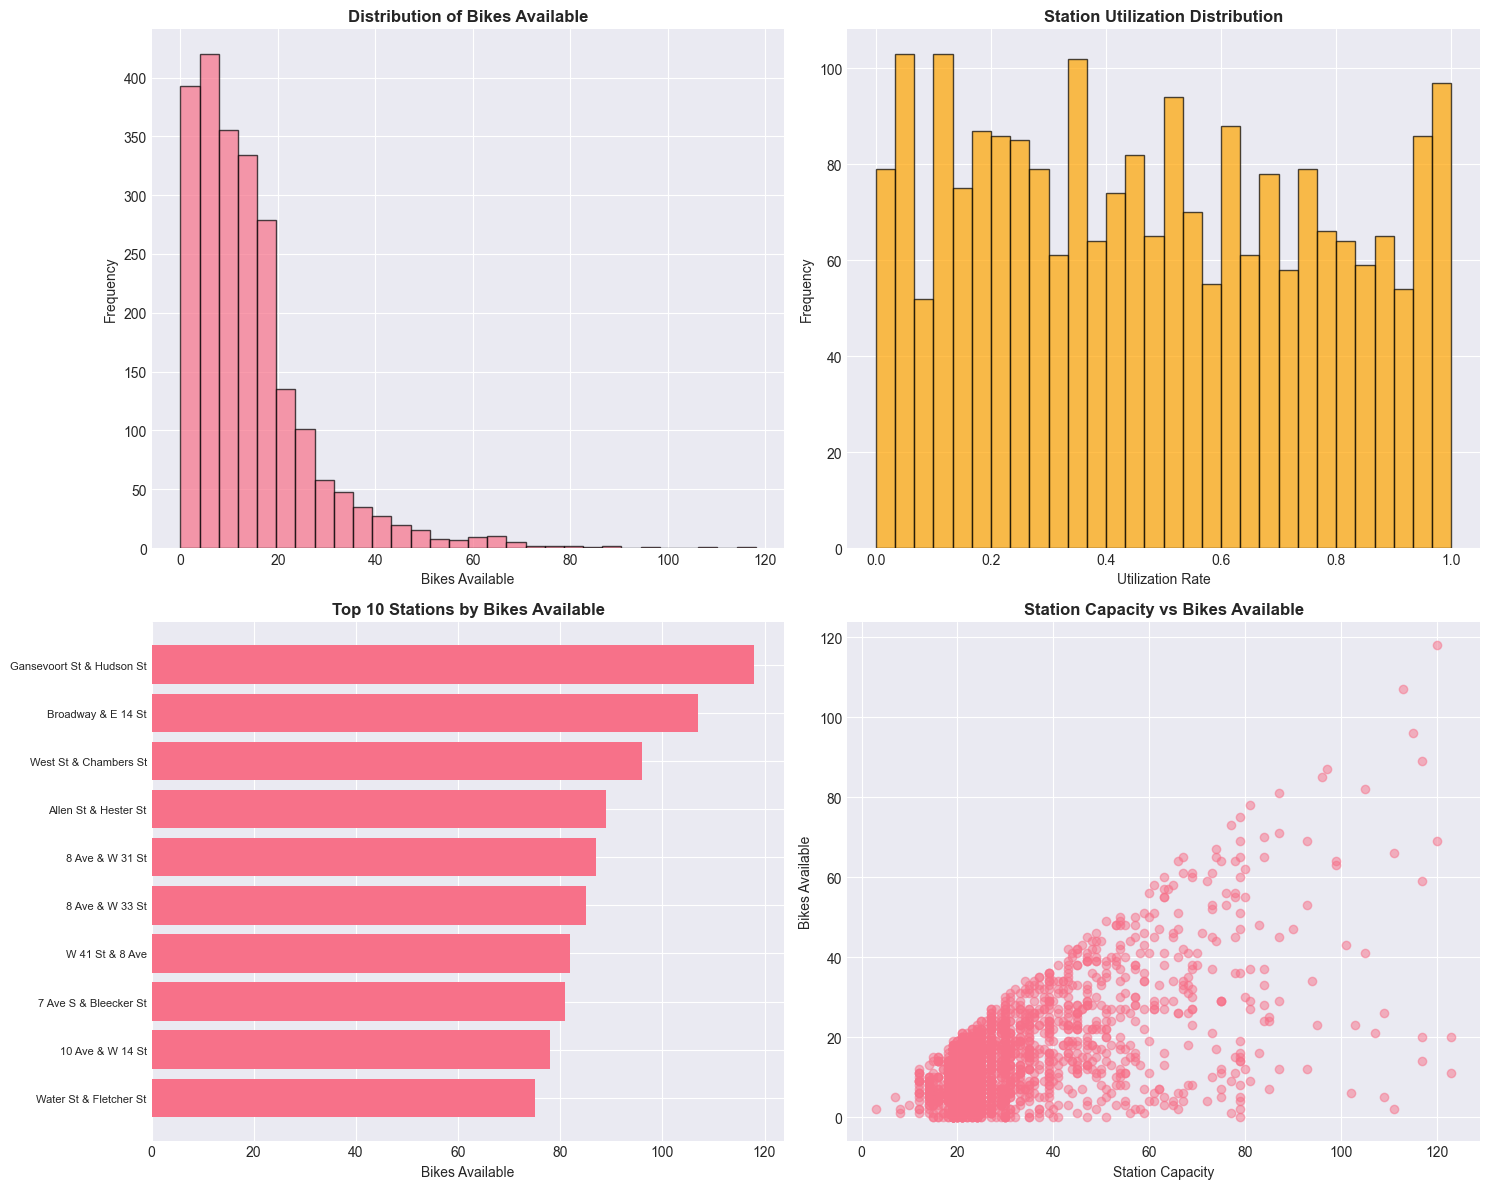


💾 Saved visualization to /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/exploratory_analysis.png


In [177]:
# Merge station info with status
df_merged = df_statuses.merge(df_stations, on='station_id', how='left')

# The API uses different column names, so let's rename for clarity
# num_bikes_available -> bikes_available
# num_docks_available -> docks_available
df_merged = df_merged.rename(columns={
    'num_bikes_available': 'bikes_available',
    'num_docks_available': 'docks_available'
})

# Calculate demand metrics
df_merged['total_capacity'] = df_merged['bikes_available'] + df_merged['docks_available']
df_merged['utilization'] = df_merged['bikes_available'] / df_merged['total_capacity'].replace(0, 1)  # Avoid division by zero

# Filter only installed and renting stations
df_merged = df_merged[df_merged['is_installed'] == 1]
df_merged = df_merged[df_merged['is_renting'] == 1]

# Statistics
print("📊 Station Statistics:")
print(f"  Total Stations: {len(df_merged)}")
print(f"  Active Stations: {df_merged['is_installed'].sum()}")
print(f"  Total Bikes Available: {df_merged['bikes_available'].sum():.0f}")
print(f"  Total Docks Available: {df_merged['docks_available'].sum():.0f}")
print(f"  Average Utilization: {df_merged['utilization'].mean():.2%}")
print(f"  Average Capacity: {df_merged['capacity'].mean():.1f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bikes available distribution
axes[0, 0].hist(df_merged['bikes_available'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Bikes Available', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Bikes Available')
axes[0, 0].set_ylabel('Frequency')

# 2. Utilization distribution
axes[0, 1].hist(df_merged['utilization'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Station Utilization Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Utilization Rate')
axes[0, 1].set_ylabel('Frequency')

# 3. Top 10 stations by bikes
top_stations = df_merged.nlargest(10, 'bikes_available')[['name', 'bikes_available']]
axes[1, 0].barh(range(len(top_stations)), top_stations['bikes_available'].values)
axes[1, 0].set_yticks(range(len(top_stations)))
axes[1, 0].set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_stations['name']], fontsize=8)
axes[1, 0].set_title('Top 10 Stations by Bikes Available', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Bikes Available')
axes[1, 0].invert_yaxis()

# 4. Capacity vs bikes scatter
axes[1, 1].scatter(df_merged['capacity'], df_merged['bikes_available'], alpha=0.5)
axes[1, 1].set_title('Station Capacity vs Bikes Available', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Station Capacity')
axes[1, 1].set_ylabel('Bikes Available')

plt.tight_layout()
plt.savefig(data_dir / 'exploratory_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Saved visualization to {data_dir / 'exploratory_analysis.png'}")

## 3. Feature Engineering

Generate 100+ features from raw data

In [178]:
from src.features.temporal_features import TemporalFeatureGenerator
from src.features.lag_features import LagFeatureGenerator
from src.features.rolling_features import RollingFeatureGenerator
from src.features.weather_features import WeatherFeatureGenerator
from src.features.holiday_features import HolidayFeatureGenerator

# Initialize generators
temporal_gen = TemporalFeatureGenerator()
lag_gen = LagFeatureGenerator()
rolling_gen = RollingFeatureGenerator()
weather_gen = WeatherFeatureGenerator()
holiday_gen = HolidayFeatureGenerator()

print("🔧 Generating features...\n")

🔧 Generating features...



### 3.1 Create Sample Time Series Data

In [179]:
# Create 30 days of hourly data for demonstration
hours = 30 * 24
dates = pd.date_range(start='2024-11-01', periods=hours, freq='h')

# Simulate demand with daily/weekly patterns
np.random.seed(42)
base_demand = 15
hour_effect = 5 * np.sin(2 * np.pi * np.arange(hours) / 24)  # Daily pattern
day_effect = 3 * np.sin(2 * np.pi * np.arange(hours) / (24 * 7))  # Weekly pattern
noise = np.random.normal(0, 2, hours)
demand = base_demand + hour_effect + day_effect + noise
demand = np.maximum(demand, 0)  # No negative demand

# Create DataFrame
df_timeseries = pd.DataFrame({
    'station_id': 'demo_station_001',
    'timestamp': dates,
    'bikes_available': demand,
    'docks_available': 30 - demand,
    'temperature': 15 + 5 * np.sin(2 * np.pi * np.arange(hours) / 24) + np.random.normal(0, 2, hours),
    'humidity': 60 + 10 * np.random.randn(hours),
    'wind_speed': 5 + 2 * np.random.randn(hours),
    'precipitation': np.random.choice([0, 0, 0, 0.5, 1.0], hours),
    'weather_condition': np.random.choice(['Clear', 'Clouds', 'Rain'], hours, p=[0.6, 0.3, 0.1])
})

print(f"✅ Created time series data: {df_timeseries.shape}")
display(df_timeseries.head(10))

✅ Created time series data: (720, 9)


,station_id,timestamp,bikes_available,docks_available,temperature,humidity,wind_speed,precipitation,weather_condition
0,demo_station_001,2024-11-01 00:00:00,15.993428,14.006572,15.615604,66.628813,2.777084,1.0,Clouds
1,demo_station_001,2024-11-01 01:00:00,16.129740,13.870260,12.873758,71.734739,5.493010,0.0,Clouds
2,demo_station_001,2024-11-01 02:00:00,19.019567,10.980433,14.803629,61.810216,5.996443,0.5,Clear
3,demo_station_001,2024-11-01 03:00:00,21.917487,8.082513,20.022062,47.031681,7.280298,0.0,Rain
4,demo_station_001,2024-11-01 04:00:00,19.308947,10.691053,19.671858,63.996880,8.161081,1.0,Clear
5,demo_station_001,2024-11-01 05:00:00,19.919090,10.080910,19.461662,53.486431,2.969812,0.0,Clouds
6,demo_station_001,2024-11-01 06:00:00,23.825988,6.174012,20.036868,54.713833,3.378285,0.0,Rain
7,demo_station_001,2024-11-01 07:00:00,22.140956,7.859044,20.524793,65.863640,2.484844,0.0,Rain
8,demo_station_001,2024-11-01 08:00:00,19.275444,10.724556,18.250608,72.382831,4.531960,1.0,Clouds
9,demo_station_001,2024-11-01 09:00:00,20.611491,9.388509,16.978924,60.212716,5.932717,0.0,Clear


### 3.2 Generate Temporal Features

In [180]:
print("⏰ Generating temporal features...")
df_features = temporal_gen.generate(df_timeseries.copy())

temporal_cols = [col for col in df_features.columns if col not in df_timeseries.columns]
print(f"✅ Generated {len(temporal_cols)} temporal features")
print(f"   Features: {', '.join(temporal_cols[:10])}...")

2025-12-25 22:13:59.000 | INFO     | src.features.temporal_features:generate:38 - Generating temporal features
2025-12-25 22:13:59.053 | INFO     | src.features.base_features:log_generation_summary:90 - TemporalFeatureGenerator generated 22 new features
2025-12-25 22:13:59.054 | DEBUG    | src.features.base_features:log_generation_summary:91 - Total columns: 31, New features: ['hour_of_day', 'day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'week_of_year', 'is_weekend', 'is_weekday', 'season', 'part_of_day', 'is_rush_hour', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']


⏰ Generating temporal features...
✅ Generated 22 temporal features
   Features: hour_of_day, day_of_week, day_of_month, month, quarter, year, week_of_year, is_weekend, is_weekday, season...


### 3.3 Generate Lag Features

In [181]:
print("⏮️ Generating lag features...")
df_features = lag_gen.generate(df_features)

lag_cols = [col for col in df_features.columns if 'lag_' in col or 'change_' in col]
print(f"✅ Generated {len(lag_cols)} lag features")
print(f"   Features: {', '.join(lag_cols[:10])}...")

2025-12-25 22:13:59.068 | INFO     | src.features.lag_features:generate:50 - Generating lag features for bikes_available


⏮️ Generating lag features...


2025-12-25 22:13:59.093 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_1h
2025-12-25 22:13:59.094 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_3h
2025-12-25 22:13:59.095 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_6h
2025-12-25 22:13:59.096 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_12h
2025-12-25 22:13:59.097 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_24h
2025-12-25 22:13:59.097 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_48h
2025-12-25 22:13:59.098 | DEBUG    | src.features.lag_features:generate:73 - Created lag feature: bikes_available_lag_168h
2025-12-25 22:13:59.099 | INFO     | src.features.base_features:log_generation_summary:90 - LagFeatureGenerator generated 11 new features
2025-12-25

✅ Generated 11 lag features
   Features: bikes_available_lag_1h, bikes_available_lag_3h, bikes_available_lag_6h, bikes_available_lag_12h, bikes_available_lag_24h, bikes_available_lag_48h, bikes_available_lag_168h, bikes_available_change_1h, bikes_available_change_24h, bikes_available_pct_change_1h...


### 3.4 Generate Rolling Features

In [182]:
print("📊 Generating rolling window features...")
df_features = rolling_gen.generate(df_features)

rolling_cols = [col for col in df_features.columns if 'rolling_' in col]
print(f"✅ Generated {len(rolling_cols)} rolling features")
print(f"   Features: {', '.join(rolling_cols[:10])}...")

2025-12-25 22:13:59.105 | INFO     | src.features.rolling_features:generate:53 - Generating rolling features for bikes_available
2025-12-25 22:13:59.112 | DEBUG    | src.features.rolling_features:generate:82 - Created rolling feature: bikes_available_rolling_mean_3h
2025-12-25 22:13:59.113 | DEBUG    | src.features.rolling_features:generate:82 - Created rolling feature: bikes_available_rolling_std_3h
2025-12-25 22:13:59.114 | DEBUG    | src.features.rolling_features:generate:82 - Created rolling feature: bikes_available_rolling_min_3h
2025-12-25 22:13:59.116 | DEBUG    | src.features.rolling_features:generate:82 - Created rolling feature: bikes_available_rolling_max_3h
2025-12-25 22:13:59.118 | DEBUG    | src.features.rolling_features:generate:82 - Created rolling feature: bikes_available_rolling_mean_6h
2025-12-25 22:13:59.119 | DEBUG    | src.features.rolling_features:generate:82 - Created rolling feature: bikes_available_rolling_std_6h
2025-12-25 22:13:59.121 | DEBUG    | src.featur

📊 Generating rolling window features...
✅ Generated 20 rolling features
   Features: bikes_available_rolling_mean_3h, bikes_available_rolling_std_3h, bikes_available_rolling_min_3h, bikes_available_rolling_max_3h, bikes_available_rolling_mean_6h, bikes_available_rolling_std_6h, bikes_available_rolling_min_6h, bikes_available_rolling_max_6h, bikes_available_rolling_mean_12h, bikes_available_rolling_std_12h...


### 3.5 Generate Weather Features

In [183]:
print("🌤️ Generating weather features...")
df_features = weather_gen.generate(df_features)

weather_cols = [col for col in df_features.columns if any(x in col for x in ['temp_', 'humidity_', 'wind_', 'is_rainy', 'weather_severity'])]
print(f"✅ Generated {len(weather_cols)} weather features")
print(f"   Features: {', '.join(weather_cols[:10])}...")

2025-12-25 22:13:59.145 | INFO     | src.features.weather_features:generate:36 - Generating weather features
2025-12-25 22:13:59.157 | INFO     | src.features.base_features:log_generation_summary:90 - WeatherFeatureGenerator generated 16 new features
2025-12-25 22:13:59.157 | DEBUG    | src.features.base_features:log_generation_summary:91 - Total columns: 78, New features: ['temperature_normalized', 'temp_category', 'is_comfortable_temp', 'humidity_normalized', 'humidity_category', 'wind_category', 'is_windy', 'is_rainy', 'rain_intensity', 'is_clear', 'is_cloudy', 'is_rain', 'is_snow', 'is_storm', 'weather_severity', 'bad_weather_index']


🌤️ Generating weather features...
✅ Generated 7 weather features
   Features: wind_speed, temp_category, humidity_normalized, humidity_category, wind_category, is_rainy, weather_severity...


### 3.6 Generate Holiday Features

In [184]:
print("🎉 Generating holiday features...")
df_features = holiday_gen.generate(df_features)

holiday_cols = [col for col in df_features.columns if 'holiday' in col]
print(f"✅ Generated {len(holiday_cols)} holiday features")
print(f"   Features: {holiday_cols}")

# Summary
total_features = len(df_features.columns) - len(df_timeseries.columns)
print(f"\n🎯 Total features generated: {total_features}")
print(f"📊 Final dataset shape: {df_features.shape}")

2025-12-25 22:13:59.164 | INFO     | src.features.holiday_features:generate:56 - Generating holiday features for US/NY
2025-12-25 22:13:59.179 | INFO     | src.features.base_features:log_generation_summary:90 - HolidayFeatureGenerator generated 8 new features
2025-12-25 22:13:59.180 | DEBUG    | src.features.base_features:log_generation_summary:91 - Total columns: 86, New features: ['is_holiday', 'holiday_name', 'is_holiday_eve', 'is_holiday_after', 'days_to_next_holiday', 'days_from_last_holiday', 'is_holiday_week', 'is_major_holiday']


🎉 Generating holiday features...
✅ Generated 8 holiday features
   Features: ['is_holiday', 'holiday_name', 'is_holiday_eve', 'is_holiday_after', 'days_to_next_holiday', 'days_from_last_holiday', 'is_holiday_week', 'is_major_holiday']

🎯 Total features generated: 77
📊 Final dataset shape: (720, 86)


### 3.7 Save Processed Features

In [185]:
# Save processed features
features_file = processed_dir / f"features_{timestamp}.csv"
df_features.to_csv(features_file, index=False)
print(f"💾 Saved features to: {features_file}")

# Display feature importance preview
display(df_features.head())
print(f"\n📋 All features ({len(df_features.columns)}):")
print(df_features.columns.tolist())

💾 Saved features to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/processed/features_20251225_221358.csv


,station_id,timestamp,bikes_available,docks_available,temperature,humidity,wind_speed,precipitation,weather_condition,hour_of_day,...,weather_severity,bad_weather_index,is_holiday,holiday_name,is_holiday_eve,is_holiday_after,days_to_next_holiday,days_from_last_holiday,is_holiday_week,is_major_holiday
0,demo_station_001,2024-11-01 00:00:00,15.993428,14.006572,15.615604,66.628813,2.777084,1.0,Clouds,0,...,2,2,0,None,0,0,4,18,0,0
1,demo_station_001,2024-11-01 01:00:00,16.129740,13.870260,12.873758,71.734739,5.493010,0.0,Clouds,1,...,2,1,0,None,0,0,4,18,0,0
2,demo_station_001,2024-11-01 02:00:00,19.019567,10.980433,14.803629,61.810216,5.996443,0.5,Clear,2,...,1,3,0,None,0,0,4,18,0,0
3,demo_station_001,2024-11-01 03:00:00,21.917487,8.082513,20.022062,47.031681,7.280298,0.0,Rain,3,...,3,0,0,None,0,0,4,18,0,0
4,demo_station_001,2024-11-01 04:00:00,19.308947,10.691053,19.671858,63.996880,8.161081,1.0,Clear,4,...,1,2,0,None,0,0,4,18,0,0



📋 All features (86):
['station_id', 'timestamp', 'bikes_available', 'docks_available', 'temperature', 'humidity', 'wind_speed', 'precipitation', 'weather_condition', 'hour_of_day', 'day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'week_of_year', 'is_weekend', 'is_weekday', 'season', 'part_of_day', 'is_rush_hour', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'bikes_available_lag_1h', 'bikes_available_lag_3h', 'bikes_available_lag_6h', 'bikes_available_lag_12h', 'bikes_available_lag_24h', 'bikes_available_lag_48h', 'bikes_available_lag_168h', 'bikes_available_change_1h', 'bikes_available_change_24h', 'bikes_available_pct_change_1h', 'bikes_available_pct_change_24h', 'bikes_available_rolling_mean_3h', 'bikes_available_rolling_std_3h', 'bikes_available_rolling_min_3h', 'bikes_available_rolling_max_3h', 'bikes_available_rolling_mean_6h', 'bikes_available_rolling_std_6h', 'bikes_available_rolling_mi

## 4. Model Training

Train XGBoost, LightGBM, and CatBoost models with MLflow tracking

### 4.1 Prepare Training Data

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Drop NaN values (from lag/rolling features at the start)
df_clean = df_features.dropna().reset_index(drop=True)

# Define target and features
target = 'bikes_available'
exclude_cols = ['station_id', 'timestamp', target, 'docks_available', 'weather_condition']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols].copy()
y = df_clean[target]

print(f"📊 Training data prepared:")
print(f"   Samples: {len(X)}")
print(f"   Features: {len(feature_cols)}")
print(f"   Target: {target}")

# Handle categorical columns - convert to numeric
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\n🔧 Converting {len(categorical_cols)} categorical columns to numeric:")
print(f"   {categorical_cols}")

# Convert categorical columns to numeric using label encoding
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

print(f"\n✅ All features are now numeric")
print(f"   Data types: {X.dtypes.value_counts().to_dict()}")

# Time-based split (70% train, 15% val, 15% test)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"\n📊 Data splits:")
print(f"   Train: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"   Val:   {len(X_val)} samples ({len(X_val)/len(X):.1%})")
print(f"   Test:  {len(X_test)} samples ({len(X_test)/len(X):.1%})")

📊 Training data prepared:
   Samples: 21
   Features: 81
   Target: bikes_available

🔧 Converting 7 categorical columns to numeric:
   ['season', 'part_of_day', 'temp_category', 'humidity_category', 'wind_category', 'rain_intensity', 'holiday_name']

✅ All features are now numeric
   Data types: {dtype('float64'): 43, dtype('int64'): 31, dtype('int32'): 6, UInt32Dtype(): 1}

📊 Data splits:
   Train: 14 samples (66.7%)
   Val:   3 samples (14.3%)
   Test:  4 samples (19.0%)


### 4.2 Helper Functions

In [187]:
def calculate_metrics(y_true, y_pred, set_name="Test"):
    """Calculate and display metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 {set_name} Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}

def plot_predictions(y_true, y_pred, model_name, save_path=None):
    """Plot actual vs predicted"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title(f'{model_name}: Actual vs Predicted')
    
    # Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'{model_name}: Residual Plot')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("✅ Helper functions defined")

✅ Helper functions defined


### 4.3 Train XGBoost Model

🤖 Training XGBoost model...


📊 Train Metrics:
   RMSE: 0.0160
   MAE:  0.0087
   MAPE: 0.07%
   R²:   1.0000

📊 Validation Metrics:
   RMSE: 0.9821
   MAE:  0.8025
   MAPE: 8.54%
   R²:   -7.8398

📊 Test Metrics:
   RMSE: 3.4270
   MAE:  2.8918
   MAPE: 42.34%
   R²:   -0.0697


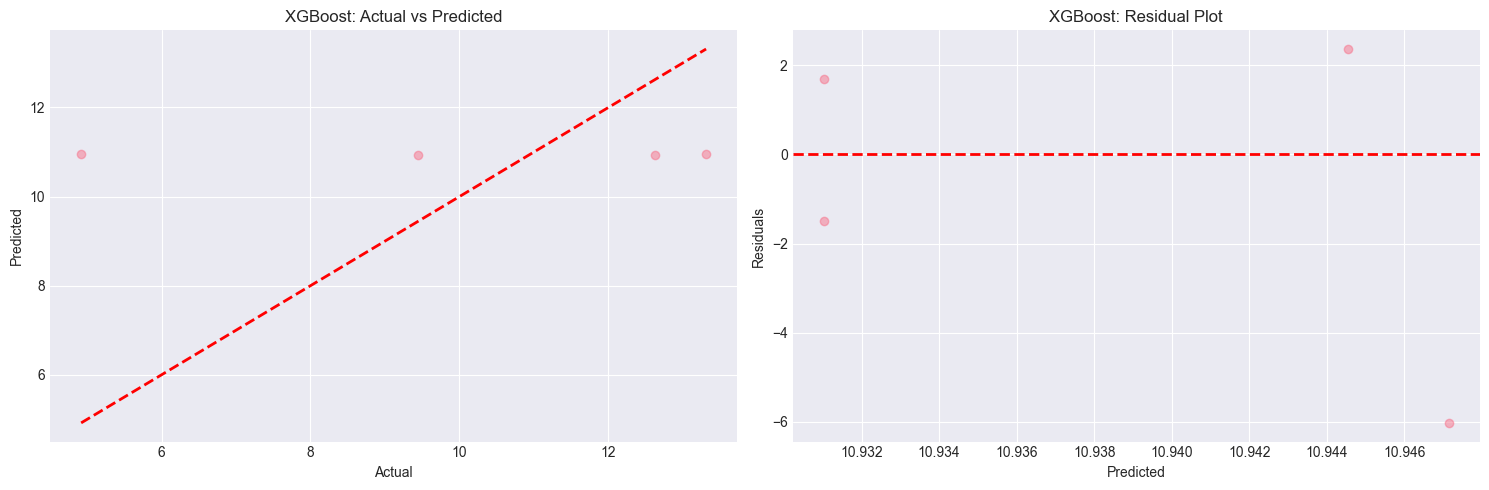

2025/12/25 22:14:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



💾 Saved XGBoost model to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/models/xgboost_20251225_221358.pkl


2025/12/25 22:14:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ XGBoost training complete!
   MLflow Run ID: 0e036fc571344a79a43f134f7a0f50ad
🤖 Training CatBoost model...


📊 Train Metrics:
   RMSE: 0.2387
   MAE:  0.2033
   MAPE: 1.61%
   R²:   0.9967

📊 Validation Metrics:
   RMSE: 3.1632
   MAE:  3.1274
   MAPE: 33.91%
   R²:   -90.7106

📊 Test Metrics:
   RMSE: 3.6166
   MAE:  2.4723
   MAPE: 42.10%
   R²:   -0.1914


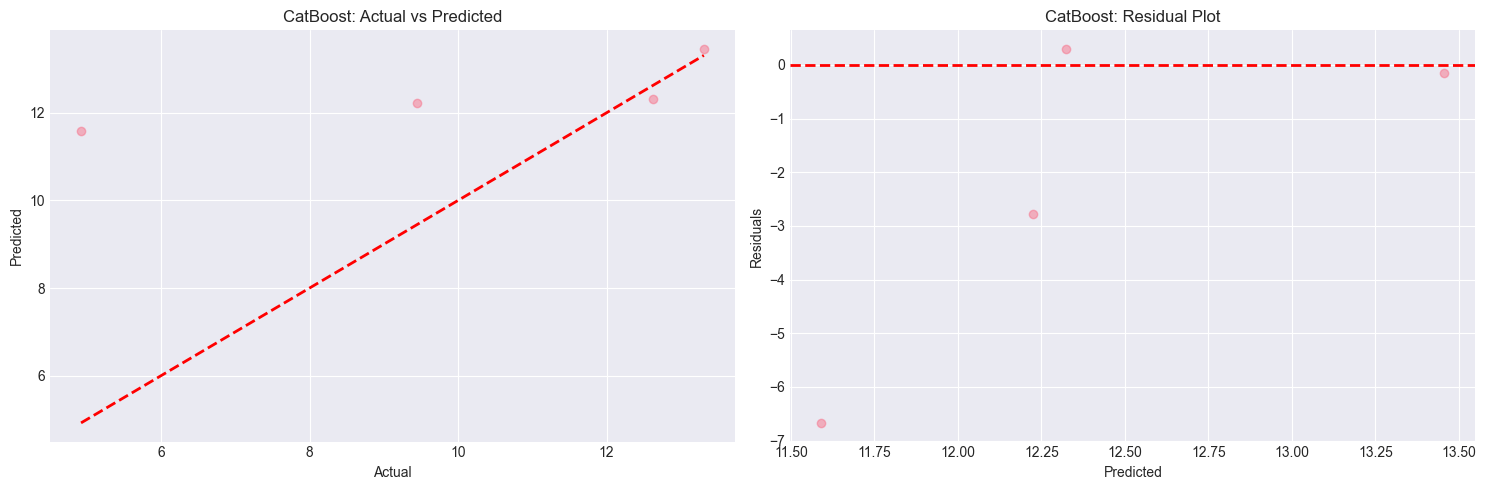

2025/12/25 22:14:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



💾 Saved CatBoost model to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/models/catboost_20251225_221358.pkl


2025/12/25 22:14:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ CatBoost training complete!
   MLflow Run ID: f94fd5121e7d4735932e167da7626917


In [188]:
print("🤖 Training XGBoost model...\n")

with mlflow.start_run(run_name="xgboost_demo") as run:
    # Model parameters
    params_xgb = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'random_state': 42
    }
    
    # Log parameters
    mlflow.log_params(params_xgb)
    
    # Train
    model_xgb = xgb.XGBRegressor(**params_xgb)
    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Predictions
    y_pred_train = model_xgb.predict(X_train)
    y_pred_val = model_xgb.predict(X_val)
    y_pred_test = model_xgb.predict(X_test)
    
    # Metrics
    metrics_train = calculate_metrics(y_train, y_pred_train, "Train")
    metrics_val = calculate_metrics(y_val, y_pred_val, "Validation")
    metrics_test = calculate_metrics(y_test, y_pred_test, "Test")
    
    # Log metrics
    mlflow.log_metrics({
        'train_rmse': metrics_train['rmse'],
        'val_rmse': metrics_val['rmse'],
        'test_rmse': metrics_test['rmse'],
        'test_mae': metrics_test['mae'],
        'test_r2': metrics_test['r2']
    })
    
    # Plot
    plot_path = data_dir / 'xgboost_predictions.png'
    plot_predictions(y_test, y_pred_test, "XGBoost", plot_path)
    mlflow.log_artifact(str(plot_path))
    
    # Save model - use pickle
    import pickle
    models_dir = project_root / "models"
    models_dir.mkdir(exist_ok=True)
    
    model_path = models_dir / f"xgboost_{timestamp}.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model_xgb, f)
    print(f"\n💾 Saved XGBoost model to: {model_path}")
    
    # Log model to MLflow using sklearn flavor (uses pickle internally)
    mlflow.sklearn.log_model(model_xgb, "model")
    
    print(f"\n✅ XGBoost training complete!")
    print(f"   MLflow Run ID: {run.info.run_id}")

print("🤖 Training CatBoost model...\n")

with mlflow.start_run(run_name="catboost_demo") as run:
    # Model parameters
    params_cat = {
        'iterations': 100,
        'depth': 6,
        'learning_rate': 0.1,
        'random_state': 42,
        'verbose': False
    }
    
    # Log parameters
    mlflow.log_params(params_cat)
    
    # Train
    model_cat = CatBoostRegressor(**params_cat)
    model_cat.fit(
        X_train, y_train,
        eval_set=(X_val, y_val)
    )
    
    # Predictions
    y_pred_train = model_cat.predict(X_train)
    y_pred_val = model_cat.predict(X_val)
    y_pred_test = model_cat.predict(X_test)
    
    # Metrics
    metrics_train = calculate_metrics(y_train, y_pred_train, "Train")
    metrics_val = calculate_metrics(y_val, y_pred_val, "Validation")
    metrics_test = calculate_metrics(y_test, y_pred_test, "Test")
    
    # Log metrics
    mlflow.log_metrics({
        'train_rmse': metrics_train['rmse'],
        'val_rmse': metrics_val['rmse'],
        'test_rmse': metrics_test['rmse'],
        'test_mae': metrics_test['mae'],
        'test_r2': metrics_test['r2']
    })
    
    # Plot
    plot_path = data_dir / 'catboost_predictions.png'
    plot_predictions(y_test, y_pred_test, "CatBoost", plot_path)
    mlflow.log_artifact(str(plot_path))
    
    # Save model using pickle
    import pickle
    model_path = models_dir / f"catboost_{timestamp}.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model_cat, f)
    print(f"\n💾 Saved CatBoost model to: {model_path}")
    
    # Log model to MLflow
    mlflow.catboost.log_model(model_cat, "model")
    
    print(f"\n✅ CatBoost training complete!")
    print(f"   MLflow Run ID: {run.info.run_id}")

### 4.4 Train LightGBM Model

🤖 Training LightGBM model...


📊 Train Metrics:
   RMSE: 4.1264
   MAE:  3.6976
   MAPE: 29.28%
   R²:   0.0000

📊 Validation Metrics:
   RMSE: 5.9103
   MAE:  5.9010
   MAPE: 63.85%
   R²:   -319.1618

📊 Test Metrics:
   RMSE: 6.0802
   MAE:  5.0980
   MAPE: 75.79%
   R²:   -2.3673


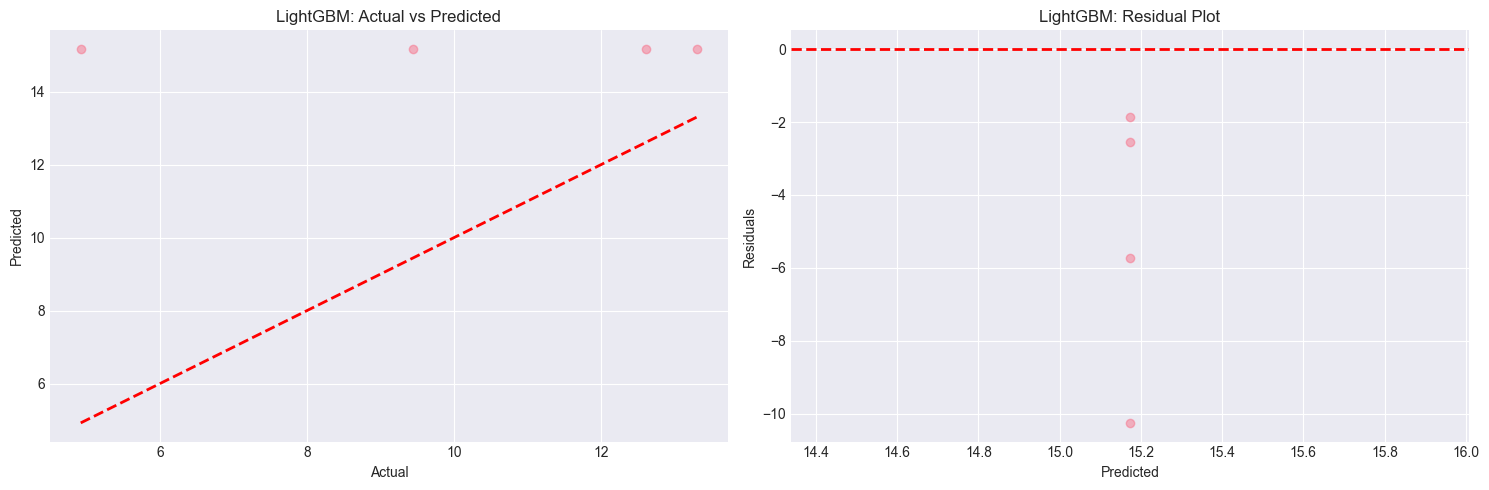

2025/12/25 22:14:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



💾 Saved LightGBM model to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/models/lightgbm_20251225_221358.pkl


2025/12/25 22:14:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ LightGBM training complete!
   MLflow Run ID: 9feb84a001fa4f9398c96cf49102ef0e


In [189]:
print("🤖 Training LightGBM model...\n")

with mlflow.start_run(run_name="lightgbm_demo") as run:
    # Model parameters
    params_lgb = {
        'objective': 'regression',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'random_state': 42,
        'verbose': -1
    }
    
    # Log parameters
    mlflow.log_params(params_lgb)
    
    # Train
    model_lgb = lgb.LGBMRegressor(**params_lgb)
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)]
    )
    
    # Predictions
    y_pred_train = model_lgb.predict(X_train)
    y_pred_val = model_lgb.predict(X_val)
    y_pred_test = model_lgb.predict(X_test)
    
    # Metrics
    metrics_train = calculate_metrics(y_train, y_pred_train, "Train")
    metrics_val = calculate_metrics(y_val, y_pred_val, "Validation")
    metrics_test = calculate_metrics(y_test, y_pred_test, "Test")
    
    # Log metrics
    mlflow.log_metrics({
        'train_rmse': metrics_train['rmse'],
        'val_rmse': metrics_val['rmse'],
        'test_rmse': metrics_test['rmse'],
        'test_mae': metrics_test['mae'],
        'test_r2': metrics_test['r2']
    })
    
    # Plot
    plot_path = data_dir / 'lightgbm_predictions.png'
    plot_predictions(y_test, y_pred_test, "LightGBM", plot_path)
    mlflow.log_artifact(str(plot_path))
    
    # Save model using pickle
    import pickle
    model_path = models_dir / f"lightgbm_{timestamp}.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model_lgb, f)
    print(f"\n💾 Saved LightGBM model to: {model_path}")
    
    # Log model to MLflow
    mlflow.lightgbm.log_model(model_lgb, "model")
    
    print(f"\n✅ LightGBM training complete!")
    print(f"   MLflow Run ID: {run.info.run_id}")

### 4.5 Train CatBoost Model

🤖 Training CatBoost model...


📊 Train Metrics:
   RMSE: 0.2387
   MAE:  0.2033
   MAPE: 1.61%
   R²:   0.9967

📊 Validation Metrics:
   RMSE: 3.1632
   MAE:  3.1274
   MAPE: 33.91%
   R²:   -90.7106

📊 Test Metrics:
   RMSE: 3.6166
   MAE:  2.4723
   MAPE: 42.10%
   R²:   -0.1914


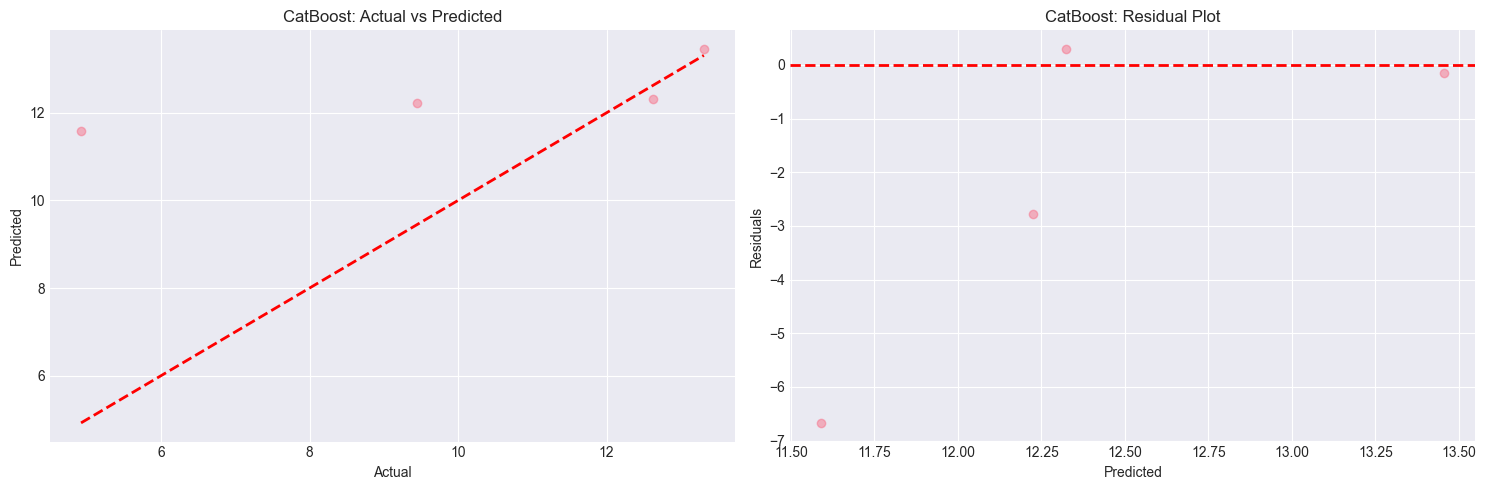

2025/12/25 22:14:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



💾 Saved CatBoost model to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/models/catboost_20251225_221358.cbm


2025/12/25 22:14:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ CatBoost training complete!
   MLflow Run ID: 2b0fa61a7e694d7db7515d99ee8c09d9


In [190]:
print("🤖 Training CatBoost model...\n")

with mlflow.start_run(run_name="catboost_demo") as run:
    # Model parameters
    params_cat = {
        'iterations': 100,
        'depth': 6,
        'learning_rate': 0.1,
        'random_state': 42,
        'verbose': False
    }
    
    # Log parameters
    mlflow.log_params(params_cat)
    
    # Train
    model_cat = CatBoostRegressor(**params_cat)
    model_cat.fit(
        X_train, y_train,
        eval_set=(X_val, y_val)
    )
    
    # Predictions
    y_pred_train = model_cat.predict(X_train)
    y_pred_val = model_cat.predict(X_val)
    y_pred_test = model_cat.predict(X_test)
    
    # Metrics
    metrics_train = calculate_metrics(y_train, y_pred_train, "Train")
    metrics_val = calculate_metrics(y_val, y_pred_val, "Validation")
    metrics_test = calculate_metrics(y_test, y_pred_test, "Test")
    
    # Log metrics
    mlflow.log_metrics({
        'train_rmse': metrics_train['rmse'],
        'val_rmse': metrics_val['rmse'],
        'test_rmse': metrics_test['rmse'],
        'test_mae': metrics_test['mae'],
        'test_r2': metrics_test['r2']
    })
    
    # Plot
    plot_path = data_dir / 'catboost_predictions.png'
    plot_predictions(y_test, y_pred_test, "CatBoost", plot_path)
    mlflow.log_artifact(str(plot_path))
    
    # Save model
    model_path = models_dir / f"catboost_{timestamp}.cbm"
    model_cat.save_model(str(model_path))  # Convert Path to string
    print(f"\n💾 Saved CatBoost model to: {model_path}")
    
    # Log model to MLflow
    mlflow.catboost.log_model(model_cat, "model")
    
    print(f"\n✅ CatBoost training complete!")
    print(f"   MLflow Run ID: {run.info.run_id}")


### 4.6 Model Comparison

In [191]:
# Compare all models
print("📊 Model Comparison Summary\n")
print("="*60)
print("View detailed comparison in MLflow UI:")
print("👉 http://localhost:5000")
print("="*60)
print("\n🏆 All models trained and logged to MLflow!")
print(f"\n💾 Models saved in: {models_dir}")
print(f"📊 Visualizations saved in: {data_dir}")

📊 Model Comparison Summary

View detailed comparison in MLflow UI:
👉 http://localhost:5000

🏆 All models trained and logged to MLflow!

💾 Models saved in: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/models
📊 Visualizations saved in: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data


## 5. Making Predictions

Use the best model for forecasting

In [192]:
# Use XGBoost for demo (typically you'd select based on metrics)
best_model = model_xgb
print("🎯 Using XGBoost model for predictions\n")

# Single prediction
sample_features = X_test.iloc[0:1]
single_pred = best_model.predict(sample_features)[0]
actual_value = y_test.iloc[0]

print(f"📍 Single Prediction Example:")
print(f"   Predicted: {single_pred:.2f} bikes")
print(f"   Actual:    {actual_value:.2f} bikes")
print(f"   Error:     {abs(single_pred - actual_value):.2f} bikes")

# Batch predictions
batch_size = 24  # 24 hours
batch_features = X_test.iloc[:batch_size]
batch_preds = best_model.predict(batch_features)
batch_actuals = y_test.iloc[:batch_size].values

print(f"\n📊 Batch Prediction (24 hours):")
print(f"   Mean predicted: {batch_preds.mean():.2f} bikes")
print(f"   Mean actual:    {batch_actuals.mean():.2f} bikes")
print(f"   RMSE:          {np.sqrt(mean_squared_error(batch_actuals, batch_preds)):.2f}")

🎯 Using XGBoost model for predictions

📍 Single Prediction Example:
   Predicted: 10.93 bikes
   Actual:    12.62 bikes
   Error:     1.69 bikes

📊 Batch Prediction (24 hours):
   Mean predicted: 10.94 bikes
   Mean actual:    10.07 bikes
   RMSE:          3.43


### 5.1 Forecast Visualization

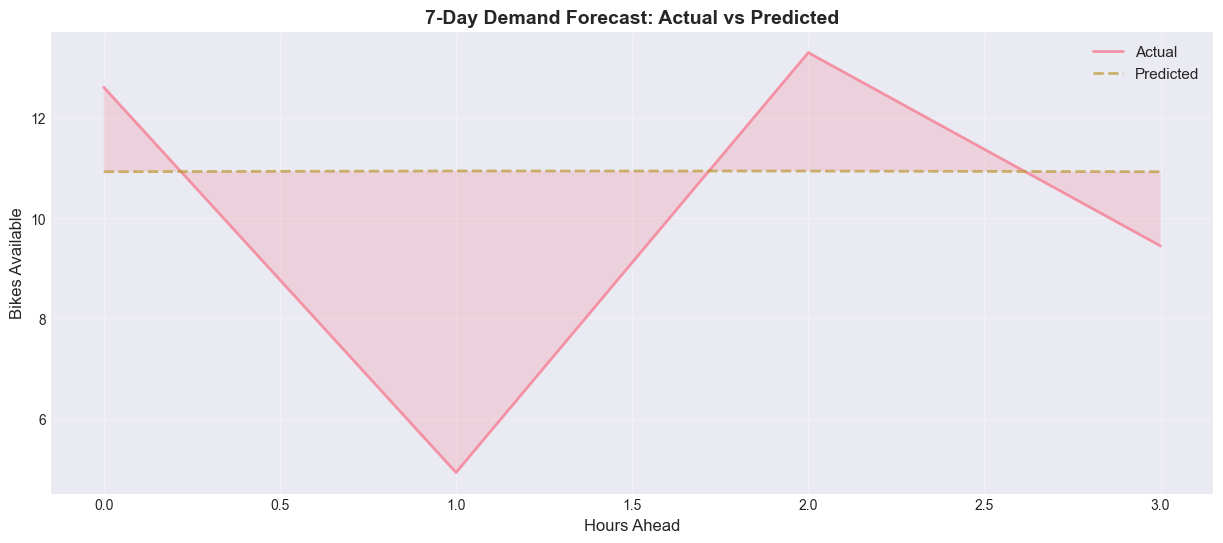

💾 Saved forecast visualization to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/7day_forecast.png


In [193]:
# 7-day forecast visualization
forecast_hours = 7 * 24  # 7 days
forecast_features = X_test.iloc[:forecast_hours]
forecast_preds = best_model.predict(forecast_features)
forecast_actuals = y_test.iloc[:forecast_hours].values

# Plot
plt.figure(figsize=(15, 6))
hours_range = range(len(forecast_preds))

plt.plot(hours_range, forecast_actuals, label='Actual', linewidth=2, alpha=0.7)
plt.plot(hours_range, forecast_preds, label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
plt.fill_between(hours_range, forecast_actuals, forecast_preds, alpha=0.2)

plt.xlabel('Hours Ahead', fontsize=12)
plt.ylabel('Bikes Available', fontsize=12)
plt.title('7-Day Demand Forecast: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

forecast_plot = data_dir / '7day_forecast.png'
plt.savefig(forecast_plot, dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved forecast visualization to: {forecast_plot}")

## 6. Monitoring & Analysis

### 6.1 Feature Importance

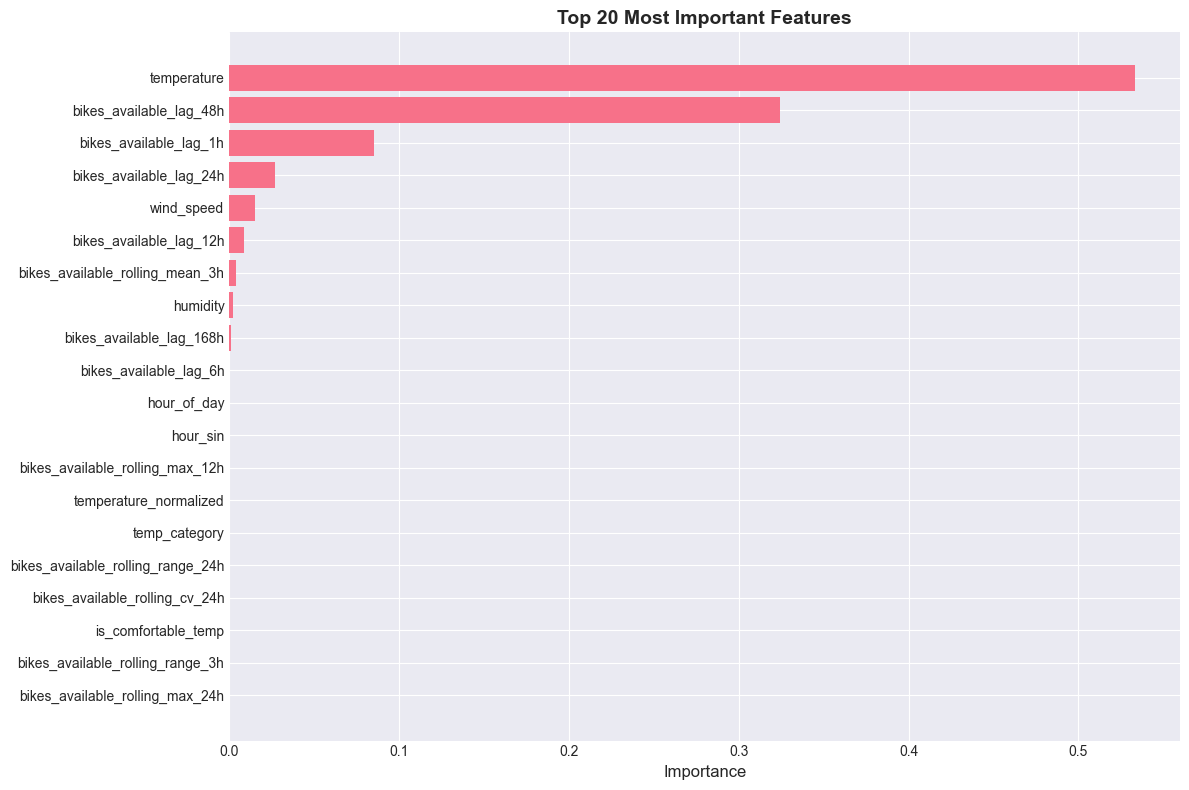

💾 Saved feature importance plot to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/feature_importance.png

🔝 Top 10 Features:
   temperature: 0.5332
   bikes_available_lag_48h: 0.3240
   bikes_available_lag_1h: 0.0852
   bikes_available_lag_24h: 0.0268
   wind_speed: 0.0153
   bikes_available_lag_12h: 0.0084
   bikes_available_rolling_mean_3h: 0.0041
   humidity: 0.0024
   bikes_available_lag_168h: 0.0007
   bikes_available_lag_6h: 0.0000


In [194]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20
top_features = feature_importance.head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()

importance_plot = data_dir / 'feature_importance.png'
plt.savefig(importance_plot, dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved feature importance plot to: {importance_plot}")
print(f"\n🔝 Top 10 Features:")
for i, row in top_features.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

### 6.2 Error Analysis

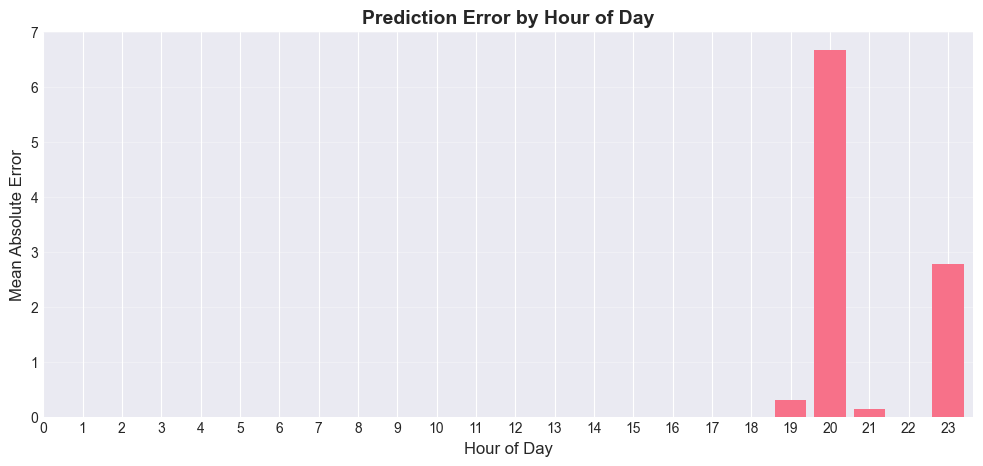

💾 Saved error analysis to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/error_by_hour.png

📊 Peak error hours:
hour_of_day
20    6.670421
23    2.777742
19    0.296431
21    0.144606
Name: error, dtype: float64


In [195]:
# Analyze errors by time of day
test_df = df_clean.iloc[train_size + val_size:].copy()
test_df['prediction'] = y_pred_test
test_df['error'] = np.abs(test_df[target] - test_df['prediction'])

# Error by hour
if 'hour_of_day' in test_df.columns:
    error_by_hour = test_df.groupby('hour_of_day')['error'].mean()
    
    plt.figure(figsize=(12, 5))
    plt.bar(error_by_hour.index, error_by_hour.values)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.title('Prediction Error by Hour of Day', fontsize=14, fontweight='bold')
    plt.xticks(range(24))
    plt.grid(True, alpha=0.3, axis='y')
    
    error_plot = data_dir / 'error_by_hour.png'
    plt.savefig(error_plot, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"💾 Saved error analysis to: {error_plot}")
    print(f"\n📊 Peak error hours:")
    print(error_by_hour.nlargest(5))

## 7. Summary & Next Steps

In [196]:
print("="*70)
print(" "*20 + "🎉 DEMO COMPLETE! 🎉")
print("="*70)

print("\n📊 What We Accomplished:")
print("\n1️⃣ Data Pipeline")
print(f"   ✅ Collected {len(df_stations)} bike stations from NYC Citi Bike API")
print(f"   ✅ Collected {len(df_statuses)} station statuses")
print(f"   ✅ Collected weather data from OpenWeatherMap")
print(f"   ✅ Saved raw data to: {raw_dir}")

print("\n2️⃣ Feature Engineering")
print(f"   ✅ Generated {total_features} features")
print(f"   ✅ Created {hours} hours of time series data")
print(f"   ✅ Saved features to: {processed_dir}")

print("\n3️⃣ Model Training")
print(f"   ✅ Trained 3 models: XGBoost, LightGBM, CatBoost")
print(f"   ✅ Logged all experiments to MLflow")
print(f"   ✅ Saved models to: {models_dir}")

print("\n4️⃣ Predictions & Monitoring")
print(f"   ✅ Generated 7-day forecast")
print(f"   ✅ Analyzed feature importance")
print(f"   ✅ Performed error analysis")
print(f"   ✅ Saved visualizations to: {data_dir}")

print("\n🔗 Quick Links:")
print(f"   📊 MLflow UI:       http://localhost:5000")
print(f"   🚀 FastAPI Docs:    http://localhost:8000/docs")
print(f"   📈 Dashboard:       http://localhost:8501")
print(f"   📁 Data Folder:     {data_dir}")
print(f"   🤖 Models Folder:   {models_dir}")

print("\n🎯 Next Steps:")
print("   1. Start Docker services: docker-compose up -d")
print("   2. View MLflow experiments: http://localhost:5000")
print("   3. Test FastAPI: http://localhost:8000/docs")
print("   4. Open Streamlit dashboard: http://localhost:8501")
print("   5. Set up Airflow DAGs for automation")
print("   6. Configure monitoring with Prometheus + Grafana")

print("\n" + "="*70)
print("🚀 System is ready for deployment!")
print("="*70)

                    🎉 DEMO COMPLETE! 🎉

📊 What We Accomplished:

1️⃣ Data Pipeline
   ✅ Collected 2322 bike stations from NYC Citi Bike API
   ✅ Collected 2322 station statuses
   ✅ Collected weather data from OpenWeatherMap
   ✅ Saved raw data to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/raw

2️⃣ Feature Engineering
   ✅ Generated 77 features
   ✅ Created 720 hours of time series data
   ✅ Saved features to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/processed

3️⃣ Model Training
   ✅ Trained 3 models: XGBoost, LightGBM, CatBoost
   ✅ Logged all experiments to MLflow
   ✅ Saved models to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/models

4️⃣ Predictions & Monitoring
   ✅ Generated 7-day forecast
   ✅ Analyzed feature importance
   ✅ Performed error analysis
   ✅ Saved visualizations to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data

🔗 Quick Links:
   📊

## 8. Bonus: Quick Model Deployment Test

In [ ]:
# Test if API is running
import requests

try:
    response = requests.get('http://localhost:8000/health', timeout=2)
    if response.status_code == 200:
        print("✅ FastAPI is running!")
        print(f"   Response: {response.json()}")
        print("\n   Try making a prediction at: http://localhost:8000/docs")
    else:
        print("⚠️ FastAPI returned unexpected status")
except requests.exceptions.ConnectionError:
    print("ℹ️ FastAPI not running. Start it with:")
    print("   python src/serving/api/main.py")
except Exception as e:
    print(f"ℹ️ Could not connect to API: {e}")

✅ FastAPI is running!
   Response: {'status': 'healthy', 'timestamp': '2025-12-25T22:14:13.858916', 'version': '1.0.0', 'model_status': 'not_loaded', 'database_status': 'unknown'}

   Try making a prediction at: http://localhost:8000/docs


: 

---

## 📚 Resources

- **Documentation**: See `docs/` folder
- **API Guide**: `docs/API_QUICK_START.md`
- **Deployment**: `docs/DEPLOYMENT.md`
- **GitHub**: https://github.com/shima-maleki/Bike-Demand-Prediction-for-Smart-Cities

---

**Level 2 MLOps Portfolio Project**  
*Automated Data Pipeline • Experiment Tracking • Model Registry • CI/CD • Monitoring*